# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
# Define dictionary describing assignment of participants to the groups

# Groups
train_groups=['HCP']

# Dictionary with study design
design = {}
design['train']={}


# Training data
for group in train_groups:

    # Idices of all subjects
    ids=[os.path.basename(path) for path in glob.glob('../../1_Data/1_Input/HCP/100307/*')]      

    path_to_folder='../../1_Data/1_Input/HCP/100307/'

    files={}
    files['brain']=path_to_folder+'t1w_1mm_iso.nii.gz'
    files['probs']=path_to_folder+'sampling_distribution.nii.gz'
    files['chiasm']=path_to_folder+'chiasm.nii.gz'

    design['train']=files

 

In [3]:
design

{'train': {'brain': '../../1_Data/1_Input/HCP/100307/t1w_1mm_iso.nii.gz',
  'probs': '../../1_Data/1_Input/HCP/100307/sampling_distribution.nii.gz',
  'chiasm': '../../1_Data/1_Input/HCP/100307/chiasm.nii.gz'}}

In [4]:
# Dictionary with all images
subjects_list = {'train': [tio.Subject(
                            t1=tio.Image(design['train']['brain'], type=tio.INTENSITY),
                            probs = tio.Image(design['train']['probs'], type = tio.INTENSITY))]}

In [5]:
subjects_list

{'train': [Subject(Keys: ('t1', 'probs'); images: 2)]}

In [6]:
# Rescale
rescale = RescaleIntensity((0,1))

transform_train = Compose([rescale]) # leaving out standardization for now


In [7]:
# Torchio's (Pytorch's) Dataset
dataset = {'train': tio.SubjectsDataset(subjects_list['train'], transform=transform_train)}

In [8]:
# Sampler
patch_size = (24,24,8)
queue_length = 600
samples_per_volume = 20

sampler = tio.data.WeightedSampler(patch_size,'probs')

In [9]:
# Dataloader
dataloader={'train': DataLoader( tio.Queue(dataset['train'], queue_length, samples_per_volume, sampler, num_workers=8), batch_size = 10)}

In [10]:
# Create dataloader for images of the chiasm exclusively

# Dictionary with all chiasm images
subjects_chiasms_list = {'train': [tio.Subject(t1=tio.Image(design['train']['chiasm'], type=tio.INTENSITY))]}

# Dataset containing only chiasm images
dataset_chiasms = {'train': tio.SubjectsDataset(subjects_chiasms_list['train'], transform = Compose([rescale]))}

# Standard dataloader with images of chiasm
# Dataloader
dataloader_chiasms={'train': DataLoader(dataset=dataset_chiasms['train'], batch_size = 10, shuffle=True, num_workers =8)}

# Network and parameters

In [11]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [12]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, init_features*scaling, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features*scaling, init_features*scaling**2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(init_features*scaling**2, init_features*scaling, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(init_features*scaling, init_features*scaling, name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(init_features*scaling, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [13]:
# 4,2 looks so far best on the brain, chiasm suboptimal - 4*2**2 = 16 -> compression 16/64
# 4,4 greatly reconstructs the brain, but is mediocre on the chiasm -> compression 1/1

# increasing number of initial layers help greatly

# Try different init_features and scaling + activation function for an output

#unet = UNet(1,1,4,4)
#unet.to(device)

In [14]:
# U-Net architecture

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=64, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features, int(init_features/(scaling)), name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
       
        self.upconv1 = nn.ConvTranspose3d(int(init_features/scaling), init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool1(enc1))
        
        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec1 = self.upconv1(bottleneck)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [15]:
# Trying very high number of initial input features that is furtherly greatly reduced
# Init features is high, scaling goes down

unet = UNet(1,1,32,2) # works perfectly

#unet = UNet(1,1,4,1)

unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc1bnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (enc1bnorm2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): AvgPool3d(kernel_size=2, stride=2, padding=0)
  (bottleneck): Sequential(
    (bottleneckconv1): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bottleneckbnorm1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bottleneckrelu1): ReLU(inplace=True)
    (bottleneckconv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (bottleneckbnorm2): BatchNorm3d(16

In [16]:
# Criterion
#criterion = DiceLoss()
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(params=unet.parameters(), lr=0.001) # previously 0.0005

# Number of epochs
n_epochs = 100

# Training

In [17]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, save_path):
    
    track_train_loss = []
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0        
        
        
        # Training
        model.train()
        
        for batch in dataloaders['train']:
            
            i = 0
            
            data = batch['t1']['data'].to(device)
            
            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
            i+=1
            
        track_train_loss.append(train_loss/i)
        
        # Print summary of epoch
        print('END OF EPOCH: {} \tTraining loss per batch: {:.6f}'.format(epoch, train_loss))
       
    # return trained model
    return model, track_train_loss

In [18]:
#trained_model, train_loss = train_network(1000, dataloader, unet, optimizer, criterion, device,'200ep_00005lr.pt')

In [19]:
trained_model, train_loss = train_network(250, dataloader, unet, optimizer, criterion, device,'1000ep_00005lr.pt')

  0%|▎                                                                             | 1/250 [00:01<04:44,  1.14s/it]

END OF EPOCH: 1 	Training loss per batch: 0.215862


  1%|▌                                                                             | 2/250 [00:02<05:05,  1.23s/it]

END OF EPOCH: 2 	Training loss per batch: 0.132634


  1%|▉                                                                             | 3/250 [00:03<04:45,  1.15s/it]

END OF EPOCH: 3 	Training loss per batch: 0.115263


  2%|█▏                                                                            | 4/250 [00:05<05:16,  1.29s/it]

END OF EPOCH: 4 	Training loss per batch: 0.102545


  2%|█▌                                                                            | 5/250 [00:06<05:21,  1.31s/it]

END OF EPOCH: 5 	Training loss per batch: 0.069187


  2%|█▊                                                                            | 6/250 [00:07<04:51,  1.19s/it]

END OF EPOCH: 6 	Training loss per batch: 0.059342


  3%|██▏                                                                           | 7/250 [00:08<04:31,  1.12s/it]

END OF EPOCH: 7 	Training loss per batch: 0.066047


  3%|██▍                                                                           | 8/250 [00:09<04:19,  1.07s/it]

END OF EPOCH: 8 	Training loss per batch: 0.068121


  4%|██▊                                                                           | 9/250 [00:10<04:07,  1.03s/it]

END OF EPOCH: 9 	Training loss per batch: 0.052423


  4%|███                                                                          | 10/250 [00:11<03:58,  1.00it/s]

END OF EPOCH: 10 	Training loss per batch: 0.051540


  4%|███▍                                                                         | 11/250 [00:12<03:53,  1.02it/s]

END OF EPOCH: 11 	Training loss per batch: 0.039923


  5%|███▋                                                                         | 12/250 [00:13<03:51,  1.03it/s]

END OF EPOCH: 12 	Training loss per batch: 0.037183


  5%|████                                                                         | 13/250 [00:14<03:49,  1.03it/s]

END OF EPOCH: 13 	Training loss per batch: 0.044576


  6%|████▎                                                                        | 14/250 [00:14<03:46,  1.04it/s]

END OF EPOCH: 14 	Training loss per batch: 0.045565


  6%|████▌                                                                        | 15/250 [00:15<03:42,  1.06it/s]

END OF EPOCH: 15 	Training loss per batch: 0.033073


  6%|████▉                                                                        | 16/250 [00:16<03:38,  1.07it/s]

END OF EPOCH: 16 	Training loss per batch: 0.037075


  7%|█████▏                                                                       | 17/250 [00:17<03:41,  1.05it/s]

END OF EPOCH: 17 	Training loss per batch: 0.033263


  7%|█████▌                                                                       | 18/250 [00:18<03:41,  1.05it/s]

END OF EPOCH: 18 	Training loss per batch: 0.023177


  8%|█████▊                                                                       | 19/250 [00:19<03:38,  1.06it/s]

END OF EPOCH: 19 	Training loss per batch: 0.020185


  8%|██████▏                                                                      | 20/250 [00:20<03:37,  1.06it/s]

END OF EPOCH: 20 	Training loss per batch: 0.021385


  8%|██████▍                                                                      | 21/250 [00:21<03:34,  1.07it/s]

END OF EPOCH: 21 	Training loss per batch: 0.019984


  9%|██████▊                                                                      | 22/250 [00:22<03:30,  1.08it/s]

END OF EPOCH: 22 	Training loss per batch: 0.014787


  9%|███████                                                                      | 23/250 [00:23<03:36,  1.05it/s]

END OF EPOCH: 23 	Training loss per batch: 0.018787


 10%|███████▍                                                                     | 24/250 [00:24<03:35,  1.05it/s]

END OF EPOCH: 24 	Training loss per batch: 0.016276


 10%|███████▋                                                                     | 25/250 [00:25<03:32,  1.06it/s]

END OF EPOCH: 25 	Training loss per batch: 0.013472


 10%|████████                                                                     | 26/250 [00:26<03:28,  1.07it/s]

END OF EPOCH: 26 	Training loss per batch: 0.012931


 11%|████████▎                                                                    | 27/250 [00:27<03:29,  1.07it/s]

END OF EPOCH: 27 	Training loss per batch: 0.018725


 11%|████████▌                                                                    | 28/250 [00:28<03:29,  1.06it/s]

END OF EPOCH: 28 	Training loss per batch: 0.013735


 12%|████████▉                                                                    | 29/250 [00:29<03:28,  1.06it/s]

END OF EPOCH: 29 	Training loss per batch: 0.012688


 12%|█████████▏                                                                   | 30/250 [00:29<03:24,  1.07it/s]

END OF EPOCH: 30 	Training loss per batch: 0.012400


 12%|█████████▌                                                                   | 31/250 [00:30<03:22,  1.08it/s]

END OF EPOCH: 31 	Training loss per batch: 0.012512


 13%|█████████▊                                                                   | 32/250 [00:31<03:21,  1.08it/s]

END OF EPOCH: 32 	Training loss per batch: 0.013609


 13%|██████████▏                                                                  | 33/250 [00:32<03:21,  1.08it/s]

END OF EPOCH: 33 	Training loss per batch: 0.006921


 14%|██████████▍                                                                  | 34/250 [00:33<03:22,  1.07it/s]

END OF EPOCH: 34 	Training loss per batch: 0.007748


 14%|██████████▊                                                                  | 35/250 [00:34<03:23,  1.05it/s]

END OF EPOCH: 35 	Training loss per batch: 0.010914


 14%|███████████                                                                  | 36/250 [00:35<03:17,  1.08it/s]

END OF EPOCH: 36 	Training loss per batch: 0.006539


 15%|███████████▍                                                                 | 37/250 [00:36<03:18,  1.07it/s]

END OF EPOCH: 37 	Training loss per batch: 0.008135


 15%|███████████▋                                                                 | 38/250 [00:37<03:18,  1.07it/s]

END OF EPOCH: 38 	Training loss per batch: 0.007605


 16%|████████████                                                                 | 39/250 [00:38<03:16,  1.07it/s]

END OF EPOCH: 39 	Training loss per batch: 0.005985


 16%|████████████▎                                                                | 40/250 [00:39<03:15,  1.07it/s]

END OF EPOCH: 40 	Training loss per batch: 0.004201


 16%|████████████▋                                                                | 41/250 [00:40<03:10,  1.10it/s]

END OF EPOCH: 41 	Training loss per batch: 0.003742


 17%|████████████▉                                                                | 42/250 [00:41<03:14,  1.07it/s]

END OF EPOCH: 42 	Training loss per batch: 0.004618


 17%|█████████████▏                                                               | 43/250 [00:42<03:13,  1.07it/s]

END OF EPOCH: 43 	Training loss per batch: 0.007660


 18%|█████████████▌                                                               | 44/250 [00:43<03:15,  1.05it/s]

END OF EPOCH: 44 	Training loss per batch: 0.003919


 18%|█████████████▊                                                               | 45/250 [00:44<03:15,  1.05it/s]

END OF EPOCH: 45 	Training loss per batch: 0.002446


 18%|██████████████▏                                                              | 46/250 [00:44<03:15,  1.04it/s]

END OF EPOCH: 46 	Training loss per batch: 0.004361


 19%|██████████████▍                                                              | 47/250 [00:46<03:18,  1.02it/s]

END OF EPOCH: 47 	Training loss per batch: 0.004642


 19%|██████████████▊                                                              | 48/250 [00:47<03:19,  1.01it/s]

END OF EPOCH: 48 	Training loss per batch: 0.003831


 20%|███████████████                                                              | 49/250 [00:47<03:16,  1.02it/s]

END OF EPOCH: 49 	Training loss per batch: 0.002675


 20%|███████████████▍                                                             | 50/250 [00:48<03:15,  1.02it/s]

END OF EPOCH: 50 	Training loss per batch: 0.002130


 20%|███████████████▋                                                             | 51/250 [00:49<03:16,  1.01it/s]

END OF EPOCH: 51 	Training loss per batch: 0.004097


 21%|████████████████                                                             | 52/250 [00:50<03:14,  1.02it/s]

END OF EPOCH: 52 	Training loss per batch: 0.004203


 21%|████████████████▎                                                            | 53/250 [00:51<03:10,  1.03it/s]

END OF EPOCH: 53 	Training loss per batch: 0.002055


 22%|████████████████▋                                                            | 54/250 [00:52<03:08,  1.04it/s]

END OF EPOCH: 54 	Training loss per batch: 0.002335


 22%|████████████████▉                                                            | 55/250 [00:53<03:06,  1.05it/s]

END OF EPOCH: 55 	Training loss per batch: 0.003282


 22%|█████████████████▏                                                           | 56/250 [00:54<03:03,  1.06it/s]

END OF EPOCH: 56 	Training loss per batch: 0.002027


 23%|█████████████████▌                                                           | 57/250 [00:55<03:02,  1.06it/s]

END OF EPOCH: 57 	Training loss per batch: 0.002105


 23%|█████████████████▊                                                           | 58/250 [00:56<03:00,  1.07it/s]

END OF EPOCH: 58 	Training loss per batch: 0.002700


 24%|██████████████████▏                                                          | 59/250 [00:57<02:58,  1.07it/s]

END OF EPOCH: 59 	Training loss per batch: 0.001588


 24%|██████████████████▍                                                          | 60/250 [00:58<02:56,  1.07it/s]

END OF EPOCH: 60 	Training loss per batch: 0.002937


 24%|██████████████████▊                                                          | 61/250 [00:59<02:58,  1.06it/s]

END OF EPOCH: 61 	Training loss per batch: 0.003244


 25%|███████████████████                                                          | 62/250 [01:00<03:00,  1.04it/s]

END OF EPOCH: 62 	Training loss per batch: 0.002037


 25%|███████████████████▍                                                         | 63/250 [01:01<02:56,  1.06it/s]

END OF EPOCH: 63 	Training loss per batch: 0.001725


 26%|███████████████████▋                                                         | 64/250 [01:02<02:55,  1.06it/s]

END OF EPOCH: 64 	Training loss per batch: 0.003192


 26%|████████████████████                                                         | 65/250 [01:03<02:52,  1.07it/s]

END OF EPOCH: 65 	Training loss per batch: 0.001674


 26%|████████████████████▎                                                        | 66/250 [01:04<02:53,  1.06it/s]

END OF EPOCH: 66 	Training loss per batch: 0.001901


 27%|████████████████████▋                                                        | 67/250 [01:05<02:53,  1.06it/s]

END OF EPOCH: 67 	Training loss per batch: 0.002481


 27%|████████████████████▉                                                        | 68/250 [01:05<02:51,  1.06it/s]

END OF EPOCH: 68 	Training loss per batch: 0.003430


 28%|█████████████████████▎                                                       | 69/250 [01:06<02:49,  1.07it/s]

END OF EPOCH: 69 	Training loss per batch: 0.002075


 28%|█████████████████████▌                                                       | 70/250 [01:07<02:47,  1.07it/s]

END OF EPOCH: 70 	Training loss per batch: 0.004288


 28%|█████████████████████▊                                                       | 71/250 [01:08<02:48,  1.07it/s]

END OF EPOCH: 71 	Training loss per batch: 0.002736


 29%|██████████████████████▏                                                      | 72/250 [01:09<02:48,  1.06it/s]

END OF EPOCH: 72 	Training loss per batch: 0.001909


 29%|██████████████████████▍                                                      | 73/250 [01:10<02:47,  1.06it/s]

END OF EPOCH: 73 	Training loss per batch: 0.002877


 30%|██████████████████████▊                                                      | 74/250 [01:11<02:45,  1.07it/s]

END OF EPOCH: 74 	Training loss per batch: 0.001907


 30%|███████████████████████                                                      | 75/250 [01:12<02:43,  1.07it/s]

END OF EPOCH: 75 	Training loss per batch: 0.003020


 30%|███████████████████████▍                                                     | 76/250 [01:13<02:45,  1.05it/s]

END OF EPOCH: 76 	Training loss per batch: 0.001644


 31%|███████████████████████▋                                                     | 77/250 [01:14<02:45,  1.05it/s]

END OF EPOCH: 77 	Training loss per batch: 0.002000


 31%|████████████████████████                                                     | 78/250 [01:15<02:43,  1.05it/s]

END OF EPOCH: 78 	Training loss per batch: 0.001448


 32%|████████████████████████▎                                                    | 79/250 [01:16<02:41,  1.06it/s]

END OF EPOCH: 79 	Training loss per batch: 0.002010


 32%|████████████████████████▋                                                    | 80/250 [01:17<02:39,  1.07it/s]

END OF EPOCH: 80 	Training loss per batch: 0.001451


 32%|████████████████████████▉                                                    | 81/250 [01:18<02:41,  1.05it/s]

END OF EPOCH: 81 	Training loss per batch: 0.001972


 33%|█████████████████████████▎                                                   | 82/250 [01:19<02:40,  1.05it/s]

END OF EPOCH: 82 	Training loss per batch: 0.002758


 33%|█████████████████████████▌                                                   | 83/250 [01:20<02:40,  1.04it/s]

END OF EPOCH: 83 	Training loss per batch: 0.002906


 34%|█████████████████████████▊                                                   | 84/250 [01:21<02:36,  1.06it/s]

END OF EPOCH: 84 	Training loss per batch: 0.002035


 34%|██████████████████████████▏                                                  | 85/250 [01:22<02:33,  1.07it/s]

END OF EPOCH: 85 	Training loss per batch: 0.001477


 34%|██████████████████████████▍                                                  | 86/250 [01:22<02:32,  1.08it/s]

END OF EPOCH: 86 	Training loss per batch: 0.001554


 35%|██████████████████████████▊                                                  | 87/250 [01:23<02:32,  1.07it/s]

END OF EPOCH: 87 	Training loss per batch: 0.001766


 35%|███████████████████████████                                                  | 88/250 [01:24<02:30,  1.07it/s]

END OF EPOCH: 88 	Training loss per batch: 0.001710


 36%|███████████████████████████▍                                                 | 89/250 [01:25<02:29,  1.08it/s]

END OF EPOCH: 89 	Training loss per batch: 0.002555


 36%|███████████████████████████▋                                                 | 90/250 [01:26<02:32,  1.05it/s]

END OF EPOCH: 90 	Training loss per batch: 0.001461


 36%|████████████████████████████                                                 | 91/250 [01:27<02:32,  1.04it/s]

END OF EPOCH: 91 	Training loss per batch: 0.002921


 37%|████████████████████████████▎                                                | 92/250 [01:28<02:32,  1.03it/s]

END OF EPOCH: 92 	Training loss per batch: 0.001592


 37%|████████████████████████████▋                                                | 93/250 [01:29<02:29,  1.05it/s]

END OF EPOCH: 93 	Training loss per batch: 0.001521


 38%|████████████████████████████▉                                                | 94/250 [01:30<02:28,  1.05it/s]

END OF EPOCH: 94 	Training loss per batch: 0.001946


 38%|█████████████████████████████▎                                               | 95/250 [01:31<02:29,  1.04it/s]

END OF EPOCH: 95 	Training loss per batch: 0.001637


 38%|█████████████████████████████▌                                               | 96/250 [01:32<02:30,  1.03it/s]

END OF EPOCH: 96 	Training loss per batch: 0.002140


 39%|█████████████████████████████▉                                               | 97/250 [01:33<02:26,  1.04it/s]

END OF EPOCH: 97 	Training loss per batch: 0.001814


 39%|██████████████████████████████▏                                              | 98/250 [01:34<02:24,  1.05it/s]

END OF EPOCH: 98 	Training loss per batch: 0.003165


 40%|██████████████████████████████▍                                              | 99/250 [01:35<02:22,  1.06it/s]

END OF EPOCH: 99 	Training loss per batch: 0.001896


 40%|██████████████████████████████▍                                             | 100/250 [01:36<02:21,  1.06it/s]

END OF EPOCH: 100 	Training loss per batch: 0.001344


 40%|██████████████████████████████▋                                             | 101/250 [01:37<02:22,  1.05it/s]

END OF EPOCH: 101 	Training loss per batch: 0.001856


 41%|███████████████████████████████                                             | 102/250 [01:38<02:20,  1.06it/s]

END OF EPOCH: 102 	Training loss per batch: 0.001465


 41%|███████████████████████████████▎                                            | 103/250 [01:39<02:17,  1.07it/s]

END OF EPOCH: 103 	Training loss per batch: 0.002067


 42%|███████████████████████████████▌                                            | 104/250 [01:40<02:17,  1.06it/s]

END OF EPOCH: 104 	Training loss per batch: 0.001777


 42%|███████████████████████████████▉                                            | 105/250 [01:40<02:15,  1.07it/s]

END OF EPOCH: 105 	Training loss per batch: 0.001399


 42%|████████████████████████████████▏                                           | 106/250 [01:41<02:16,  1.05it/s]

END OF EPOCH: 106 	Training loss per batch: 0.001633


 43%|████████████████████████████████▌                                           | 107/250 [01:42<02:12,  1.08it/s]

END OF EPOCH: 107 	Training loss per batch: 0.002104


 43%|████████████████████████████████▊                                           | 108/250 [01:43<02:12,  1.07it/s]

END OF EPOCH: 108 	Training loss per batch: 0.002001


 44%|█████████████████████████████████▏                                          | 109/250 [01:44<02:09,  1.09it/s]

END OF EPOCH: 109 	Training loss per batch: 0.001329


 44%|█████████████████████████████████▍                                          | 110/250 [01:45<02:10,  1.08it/s]

END OF EPOCH: 110 	Training loss per batch: 0.001210


 44%|█████████████████████████████████▋                                          | 111/250 [01:46<02:09,  1.07it/s]

END OF EPOCH: 111 	Training loss per batch: 0.001757


 45%|██████████████████████████████████                                          | 112/250 [01:47<02:09,  1.07it/s]

END OF EPOCH: 112 	Training loss per batch: 0.001473


 45%|██████████████████████████████████▎                                         | 113/250 [01:48<02:09,  1.06it/s]

END OF EPOCH: 113 	Training loss per batch: 0.001571


 46%|██████████████████████████████████▋                                         | 114/250 [01:49<02:07,  1.07it/s]

END OF EPOCH: 114 	Training loss per batch: 0.001643


 46%|██████████████████████████████████▉                                         | 115/250 [01:50<02:08,  1.05it/s]

END OF EPOCH: 115 	Training loss per batch: 0.002099


 46%|███████████████████████████████████▎                                        | 116/250 [01:51<02:08,  1.05it/s]

END OF EPOCH: 116 	Training loss per batch: 0.001550


 47%|███████████████████████████████████▌                                        | 117/250 [01:52<02:06,  1.05it/s]

END OF EPOCH: 117 	Training loss per batch: 0.001960


 47%|███████████████████████████████████▊                                        | 118/250 [01:53<02:05,  1.05it/s]

END OF EPOCH: 118 	Training loss per batch: 0.001138


 48%|████████████████████████████████████▏                                       | 119/250 [01:54<02:03,  1.06it/s]

END OF EPOCH: 119 	Training loss per batch: 0.001702


 48%|████████████████████████████████████▍                                       | 120/250 [01:55<02:05,  1.04it/s]

END OF EPOCH: 120 	Training loss per batch: 0.001298


 48%|████████████████████████████████████▊                                       | 121/250 [01:56<02:03,  1.04it/s]

END OF EPOCH: 121 	Training loss per batch: 0.001482


 49%|█████████████████████████████████████                                       | 122/250 [01:57<02:01,  1.05it/s]

END OF EPOCH: 122 	Training loss per batch: 0.001357


 49%|█████████████████████████████████████▍                                      | 123/250 [01:57<02:00,  1.05it/s]

END OF EPOCH: 123 	Training loss per batch: 0.001423


 50%|█████████████████████████████████████▋                                      | 124/250 [01:58<01:57,  1.07it/s]

END OF EPOCH: 124 	Training loss per batch: 0.001171


 50%|██████████████████████████████████████                                      | 125/250 [01:59<01:56,  1.08it/s]

END OF EPOCH: 125 	Training loss per batch: 0.002006


 50%|██████████████████████████████████████▎                                     | 126/250 [02:00<01:54,  1.09it/s]

END OF EPOCH: 126 	Training loss per batch: 0.001227


 51%|██████████████████████████████████████▌                                     | 127/250 [02:01<01:55,  1.06it/s]

END OF EPOCH: 127 	Training loss per batch: 0.001389


 51%|██████████████████████████████████████▉                                     | 128/250 [02:02<01:54,  1.07it/s]

END OF EPOCH: 128 	Training loss per batch: 0.001062


 52%|███████████████████████████████████████▏                                    | 129/250 [02:03<01:53,  1.07it/s]

END OF EPOCH: 129 	Training loss per batch: 0.001454


 52%|███████████████████████████████████████▌                                    | 130/250 [02:04<01:52,  1.07it/s]

END OF EPOCH: 130 	Training loss per batch: 0.001689


 52%|███████████████████████████████████████▊                                    | 131/250 [02:05<01:50,  1.08it/s]

END OF EPOCH: 131 	Training loss per batch: 0.002871


 53%|████████████████████████████████████████▏                                   | 132/250 [02:06<01:50,  1.07it/s]

END OF EPOCH: 132 	Training loss per batch: 0.001559


 53%|████████████████████████████████████████▍                                   | 133/250 [02:07<01:48,  1.07it/s]

END OF EPOCH: 133 	Training loss per batch: 0.001548


 54%|████████████████████████████████████████▋                                   | 134/250 [02:08<01:47,  1.08it/s]

END OF EPOCH: 134 	Training loss per batch: 0.001611


 54%|█████████████████████████████████████████                                   | 135/250 [02:09<01:46,  1.08it/s]

END OF EPOCH: 135 	Training loss per batch: 0.002244


 54%|█████████████████████████████████████████▎                                  | 136/250 [02:10<01:46,  1.07it/s]

END OF EPOCH: 136 	Training loss per batch: 0.001108


 55%|█████████████████████████████████████████▋                                  | 137/250 [02:10<01:45,  1.08it/s]

END OF EPOCH: 137 	Training loss per batch: 0.001179


 55%|█████████████████████████████████████████▉                                  | 138/250 [02:11<01:45,  1.07it/s]

END OF EPOCH: 138 	Training loss per batch: 0.001253


 56%|██████████████████████████████████████████▎                                 | 139/250 [02:12<01:43,  1.07it/s]

END OF EPOCH: 139 	Training loss per batch: 0.001905


 56%|██████████████████████████████████████████▌                                 | 140/250 [02:13<01:43,  1.06it/s]

END OF EPOCH: 140 	Training loss per batch: 0.002143


 56%|██████████████████████████████████████████▊                                 | 141/250 [02:14<01:41,  1.08it/s]

END OF EPOCH: 141 	Training loss per batch: 0.001457


 57%|███████████████████████████████████████████▏                                | 142/250 [02:15<01:40,  1.07it/s]

END OF EPOCH: 142 	Training loss per batch: 0.001353


 57%|███████████████████████████████████████████▍                                | 143/250 [02:16<01:40,  1.06it/s]

END OF EPOCH: 143 	Training loss per batch: 0.001356


 58%|███████████████████████████████████████████▊                                | 144/250 [02:17<01:39,  1.07it/s]

END OF EPOCH: 144 	Training loss per batch: 0.001292


 58%|████████████████████████████████████████████                                | 145/250 [02:18<01:39,  1.06it/s]

END OF EPOCH: 145 	Training loss per batch: 0.001071


 58%|████████████████████████████████████████████▍                               | 146/250 [02:19<01:38,  1.06it/s]

END OF EPOCH: 146 	Training loss per batch: 0.001077


 59%|████████████████████████████████████████████▋                               | 147/250 [02:20<01:37,  1.06it/s]

END OF EPOCH: 147 	Training loss per batch: 0.001115


 59%|████████████████████████████████████████████▉                               | 148/250 [02:21<01:38,  1.04it/s]

END OF EPOCH: 148 	Training loss per batch: 0.001041


 60%|█████████████████████████████████████████████▎                              | 149/250 [02:22<01:36,  1.05it/s]

END OF EPOCH: 149 	Training loss per batch: 0.001348


 60%|█████████████████████████████████████████████▌                              | 150/250 [02:23<01:35,  1.04it/s]

END OF EPOCH: 150 	Training loss per batch: 0.001741


 60%|█████████████████████████████████████████████▉                              | 151/250 [02:24<01:33,  1.06it/s]

END OF EPOCH: 151 	Training loss per batch: 0.001517


 61%|██████████████████████████████████████████████▏                             | 152/250 [02:25<01:32,  1.06it/s]

END OF EPOCH: 152 	Training loss per batch: 0.002453


 61%|██████████████████████████████████████████████▌                             | 153/250 [02:26<01:31,  1.06it/s]

END OF EPOCH: 153 	Training loss per batch: 0.001248


 62%|██████████████████████████████████████████████▊                             | 154/250 [02:27<01:29,  1.07it/s]

END OF EPOCH: 154 	Training loss per batch: 0.001712


 62%|███████████████████████████████████████████████                             | 155/250 [02:27<01:27,  1.08it/s]

END OF EPOCH: 155 	Training loss per batch: 0.001139


 62%|███████████████████████████████████████████████▍                            | 156/250 [02:28<01:26,  1.08it/s]

END OF EPOCH: 156 	Training loss per batch: 0.001206


 63%|███████████████████████████████████████████████▋                            | 157/250 [02:29<01:26,  1.07it/s]

END OF EPOCH: 157 	Training loss per batch: 0.001455


 63%|████████████████████████████████████████████████                            | 158/250 [02:30<01:25,  1.08it/s]

END OF EPOCH: 158 	Training loss per batch: 0.001274


 64%|████████████████████████████████████████████████▎                           | 159/250 [02:31<01:26,  1.05it/s]

END OF EPOCH: 159 	Training loss per batch: 0.001431


 64%|████████████████████████████████████████████████▋                           | 160/250 [02:32<01:26,  1.04it/s]

END OF EPOCH: 160 	Training loss per batch: 0.001366


 64%|████████████████████████████████████████████████▉                           | 161/250 [02:33<01:24,  1.06it/s]

END OF EPOCH: 161 	Training loss per batch: 0.001689


 65%|█████████████████████████████████████████████████▏                          | 162/250 [02:34<01:22,  1.07it/s]

END OF EPOCH: 162 	Training loss per batch: 0.001867


 65%|█████████████████████████████████████████████████▌                          | 163/250 [02:35<01:21,  1.07it/s]

END OF EPOCH: 163 	Training loss per batch: 0.001279


 66%|█████████████████████████████████████████████████▊                          | 164/250 [02:36<01:19,  1.08it/s]

END OF EPOCH: 164 	Training loss per batch: 0.001281


 66%|██████████████████████████████████████████████████▏                         | 165/250 [02:37<01:18,  1.08it/s]

END OF EPOCH: 165 	Training loss per batch: 0.001287


 66%|██████████████████████████████████████████████████▍                         | 166/250 [02:38<01:18,  1.07it/s]

END OF EPOCH: 166 	Training loss per batch: 0.001307


 67%|██████████████████████████████████████████████████▊                         | 167/250 [02:39<01:18,  1.06it/s]

END OF EPOCH: 167 	Training loss per batch: 0.001408


 67%|███████████████████████████████████████████████████                         | 168/250 [02:40<01:16,  1.07it/s]

END OF EPOCH: 168 	Training loss per batch: 0.002130


 68%|███████████████████████████████████████████████████▍                        | 169/250 [02:41<01:14,  1.08it/s]

END OF EPOCH: 169 	Training loss per batch: 0.001254


 68%|███████████████████████████████████████████████████▋                        | 170/250 [02:41<01:14,  1.07it/s]

END OF EPOCH: 170 	Training loss per batch: 0.001110


 68%|███████████████████████████████████████████████████▉                        | 171/250 [02:42<01:13,  1.07it/s]

END OF EPOCH: 171 	Training loss per batch: 0.001447


 69%|████████████████████████████████████████████████████▎                       | 172/250 [02:43<01:13,  1.06it/s]

END OF EPOCH: 172 	Training loss per batch: 0.001124


 69%|████████████████████████████████████████████████████▌                       | 173/250 [02:44<01:12,  1.06it/s]

END OF EPOCH: 173 	Training loss per batch: 0.001812


 70%|████████████████████████████████████████████████████▉                       | 174/250 [02:45<01:12,  1.05it/s]

END OF EPOCH: 174 	Training loss per batch: 0.001285


 70%|█████████████████████████████████████████████████████▏                      | 175/250 [02:46<01:12,  1.03it/s]

END OF EPOCH: 175 	Training loss per batch: 0.001091


 70%|█████████████████████████████████████████████████████▌                      | 176/250 [02:47<01:11,  1.04it/s]

END OF EPOCH: 176 	Training loss per batch: 0.001303


 71%|█████████████████████████████████████████████████████▊                      | 177/250 [02:48<01:09,  1.05it/s]

END OF EPOCH: 177 	Training loss per batch: 0.001579


 71%|██████████████████████████████████████████████████████                      | 178/250 [02:49<01:08,  1.05it/s]

END OF EPOCH: 178 	Training loss per batch: 0.001050


 72%|██████████████████████████████████████████████████████▍                     | 179/250 [02:50<01:08,  1.04it/s]

END OF EPOCH: 179 	Training loss per batch: 0.001196


 72%|██████████████████████████████████████████████████████▋                     | 180/250 [02:51<01:06,  1.05it/s]

END OF EPOCH: 180 	Training loss per batch: 0.001910


 72%|███████████████████████████████████████████████████████                     | 181/250 [02:52<01:05,  1.06it/s]

END OF EPOCH: 181 	Training loss per batch: 0.000952


 73%|███████████████████████████████████████████████████████▎                    | 182/250 [02:53<01:04,  1.06it/s]

END OF EPOCH: 182 	Training loss per batch: 0.001095


 73%|███████████████████████████████████████████████████████▋                    | 183/250 [02:54<01:03,  1.06it/s]

END OF EPOCH: 183 	Training loss per batch: 0.001050


 74%|███████████████████████████████████████████████████████▉                    | 184/250 [02:55<01:03,  1.04it/s]

END OF EPOCH: 184 	Training loss per batch: 0.001314


 74%|████████████████████████████████████████████████████████▏                   | 185/250 [02:56<01:01,  1.05it/s]

END OF EPOCH: 185 	Training loss per batch: 0.001579


 74%|████████████████████████████████████████████████████████▌                   | 186/250 [02:57<01:00,  1.05it/s]

END OF EPOCH: 186 	Training loss per batch: 0.001351


 75%|████████████████████████████████████████████████████████▊                   | 187/250 [02:58<00:59,  1.05it/s]

END OF EPOCH: 187 	Training loss per batch: 0.001809


 75%|█████████████████████████████████████████████████████████▏                  | 188/250 [02:59<00:58,  1.06it/s]

END OF EPOCH: 188 	Training loss per batch: 0.002320


 76%|█████████████████████████████████████████████████████████▍                  | 189/250 [03:00<00:57,  1.05it/s]

END OF EPOCH: 189 	Training loss per batch: 0.001300


 76%|█████████████████████████████████████████████████████████▊                  | 190/250 [03:01<00:56,  1.06it/s]

END OF EPOCH: 190 	Training loss per batch: 0.000968


 76%|██████████████████████████████████████████████████████████                  | 191/250 [03:01<00:56,  1.05it/s]

END OF EPOCH: 191 	Training loss per batch: 0.002208


 77%|██████████████████████████████████████████████████████████▎                 | 192/250 [03:02<00:54,  1.06it/s]

END OF EPOCH: 192 	Training loss per batch: 0.001216


 77%|██████████████████████████████████████████████████████████▋                 | 193/250 [03:03<00:53,  1.06it/s]

END OF EPOCH: 193 	Training loss per batch: 0.001243


 78%|██████████████████████████████████████████████████████████▉                 | 194/250 [03:04<00:52,  1.07it/s]

END OF EPOCH: 194 	Training loss per batch: 0.000863


 78%|███████████████████████████████████████████████████████████▎                | 195/250 [03:05<00:51,  1.07it/s]

END OF EPOCH: 195 	Training loss per batch: 0.001557


 78%|███████████████████████████████████████████████████████████▌                | 196/250 [03:06<00:50,  1.08it/s]

END OF EPOCH: 196 	Training loss per batch: 0.001434


 79%|███████████████████████████████████████████████████████████▉                | 197/250 [03:07<00:49,  1.07it/s]

END OF EPOCH: 197 	Training loss per batch: 0.001689


 79%|████████████████████████████████████████████████████████████▏               | 198/250 [03:08<00:49,  1.06it/s]

END OF EPOCH: 198 	Training loss per batch: 0.001545


 80%|████████████████████████████████████████████████████████████▍               | 199/250 [03:09<00:48,  1.04it/s]

END OF EPOCH: 199 	Training loss per batch: 0.001333


 80%|████████████████████████████████████████████████████████████▊               | 200/250 [03:10<00:47,  1.04it/s]

END OF EPOCH: 200 	Training loss per batch: 0.001212


 80%|█████████████████████████████████████████████████████████████               | 201/250 [03:11<00:46,  1.05it/s]

END OF EPOCH: 201 	Training loss per batch: 0.000974


 81%|█████████████████████████████████████████████████████████████▍              | 202/250 [03:12<00:45,  1.07it/s]

END OF EPOCH: 202 	Training loss per batch: 0.001413


 81%|█████████████████████████████████████████████████████████████▋              | 203/250 [03:13<00:43,  1.07it/s]

END OF EPOCH: 203 	Training loss per batch: 0.001207


 82%|██████████████████████████████████████████████████████████████              | 204/250 [03:14<00:43,  1.07it/s]

END OF EPOCH: 204 	Training loss per batch: 0.000931


 82%|██████████████████████████████████████████████████████████████▎             | 205/250 [03:15<00:42,  1.06it/s]

END OF EPOCH: 205 	Training loss per batch: 0.001239


 82%|██████████████████████████████████████████████████████████████▌             | 206/250 [03:16<00:41,  1.06it/s]

END OF EPOCH: 206 	Training loss per batch: 0.000952


 83%|██████████████████████████████████████████████████████████████▉             | 207/250 [03:17<00:40,  1.06it/s]

END OF EPOCH: 207 	Training loss per batch: 0.001897


 83%|███████████████████████████████████████████████████████████████▏            | 208/250 [03:17<00:39,  1.06it/s]

END OF EPOCH: 208 	Training loss per batch: 0.001338


 84%|███████████████████████████████████████████████████████████████▌            | 209/250 [03:18<00:38,  1.06it/s]

END OF EPOCH: 209 	Training loss per batch: 0.001080


 84%|███████████████████████████████████████████████████████████████▊            | 210/250 [03:19<00:38,  1.05it/s]

END OF EPOCH: 210 	Training loss per batch: 0.001271


 84%|████████████████████████████████████████████████████████████████▏           | 211/250 [03:20<00:37,  1.03it/s]

END OF EPOCH: 211 	Training loss per batch: 0.001625


 85%|████████████████████████████████████████████████████████████████▍           | 212/250 [03:21<00:36,  1.04it/s]

END OF EPOCH: 212 	Training loss per batch: 0.001982


 85%|████████████████████████████████████████████████████████████████▊           | 213/250 [03:22<00:35,  1.06it/s]

END OF EPOCH: 213 	Training loss per batch: 0.000955


 86%|█████████████████████████████████████████████████████████████████           | 214/250 [03:23<00:34,  1.06it/s]

END OF EPOCH: 214 	Training loss per batch: 0.000965


 86%|█████████████████████████████████████████████████████████████████▎          | 215/250 [03:24<00:34,  1.03it/s]

END OF EPOCH: 215 	Training loss per batch: 0.001197


 86%|█████████████████████████████████████████████████████████████████▋          | 216/250 [03:25<00:33,  1.03it/s]

END OF EPOCH: 216 	Training loss per batch: 0.001012


 87%|█████████████████████████████████████████████████████████████████▉          | 217/250 [03:26<00:31,  1.05it/s]

END OF EPOCH: 217 	Training loss per batch: 0.001274


 87%|██████████████████████████████████████████████████████████████████▎         | 218/250 [03:27<00:30,  1.05it/s]

END OF EPOCH: 218 	Training loss per batch: 0.001064


 88%|██████████████████████████████████████████████████████████████████▌         | 219/250 [03:28<00:29,  1.04it/s]

END OF EPOCH: 219 	Training loss per batch: 0.001537


 88%|██████████████████████████████████████████████████████████████████▉         | 220/250 [03:29<00:29,  1.03it/s]

END OF EPOCH: 220 	Training loss per batch: 0.001365


 88%|███████████████████████████████████████████████████████████████████▏        | 221/250 [03:30<00:27,  1.04it/s]

END OF EPOCH: 221 	Training loss per batch: 0.000881


 89%|███████████████████████████████████████████████████████████████████▍        | 222/250 [03:31<00:26,  1.04it/s]

END OF EPOCH: 222 	Training loss per batch: 0.001563


 89%|███████████████████████████████████████████████████████████████████▊        | 223/250 [03:32<00:25,  1.06it/s]

END OF EPOCH: 223 	Training loss per batch: 0.001401


 90%|████████████████████████████████████████████████████████████████████        | 224/250 [03:33<00:24,  1.05it/s]

END OF EPOCH: 224 	Training loss per batch: 0.000914


 90%|████████████████████████████████████████████████████████████████████▍       | 225/250 [03:34<00:23,  1.05it/s]

END OF EPOCH: 225 	Training loss per batch: 0.001107


 90%|████████████████████████████████████████████████████████████████████▋       | 226/250 [03:35<00:22,  1.06it/s]

END OF EPOCH: 226 	Training loss per batch: 0.000775


 91%|█████████████████████████████████████████████████████████████████████       | 227/250 [03:36<00:21,  1.06it/s]

END OF EPOCH: 227 	Training loss per batch: 0.001267


 91%|█████████████████████████████████████████████████████████████████████▎      | 228/250 [03:37<00:20,  1.08it/s]

END OF EPOCH: 228 	Training loss per batch: 0.001244


 92%|█████████████████████████████████████████████████████████████████████▌      | 229/250 [03:37<00:19,  1.07it/s]

END OF EPOCH: 229 	Training loss per batch: 0.001228


 92%|█████████████████████████████████████████████████████████████████████▉      | 230/250 [03:38<00:18,  1.06it/s]

END OF EPOCH: 230 	Training loss per batch: 0.001169


 92%|██████████████████████████████████████████████████████████████████████▏     | 231/250 [03:39<00:17,  1.06it/s]

END OF EPOCH: 231 	Training loss per batch: 0.001304


 93%|██████████████████████████████████████████████████████████████████████▌     | 232/250 [03:40<00:16,  1.06it/s]

END OF EPOCH: 232 	Training loss per batch: 0.001410


 93%|██████████████████████████████████████████████████████████████████████▊     | 233/250 [03:41<00:15,  1.08it/s]

END OF EPOCH: 233 	Training loss per batch: 0.001104


 94%|███████████████████████████████████████████████████████████████████████▏    | 234/250 [03:42<00:14,  1.08it/s]

END OF EPOCH: 234 	Training loss per batch: 0.001287


 94%|███████████████████████████████████████████████████████████████████████▍    | 235/250 [03:43<00:14,  1.06it/s]

END OF EPOCH: 235 	Training loss per batch: 0.000985


 94%|███████████████████████████████████████████████████████████████████████▋    | 236/250 [03:44<00:13,  1.06it/s]

END OF EPOCH: 236 	Training loss per batch: 0.000921


 95%|████████████████████████████████████████████████████████████████████████    | 237/250 [03:45<00:12,  1.04it/s]

END OF EPOCH: 237 	Training loss per batch: 0.001279


 95%|████████████████████████████████████████████████████████████████████████▎   | 238/250 [03:46<00:11,  1.06it/s]

END OF EPOCH: 238 	Training loss per batch: 0.001381


 96%|████████████████████████████████████████████████████████████████████████▋   | 239/250 [03:47<00:10,  1.07it/s]

END OF EPOCH: 239 	Training loss per batch: 0.001207


 96%|████████████████████████████████████████████████████████████████████████▉   | 240/250 [03:48<00:09,  1.06it/s]

END OF EPOCH: 240 	Training loss per batch: 0.001488


 96%|█████████████████████████████████████████████████████████████████████████▎  | 241/250 [03:49<00:08,  1.05it/s]

END OF EPOCH: 241 	Training loss per batch: 0.001015


 97%|█████████████████████████████████████████████████████████████████████████▌  | 242/250 [03:50<00:07,  1.05it/s]

END OF EPOCH: 242 	Training loss per batch: 0.001497


 97%|█████████████████████████████████████████████████████████████████████████▊  | 243/250 [03:51<00:06,  1.06it/s]

END OF EPOCH: 243 	Training loss per batch: 0.001038


 98%|██████████████████████████████████████████████████████████████████████████▏ | 244/250 [03:52<00:05,  1.06it/s]

END OF EPOCH: 244 	Training loss per batch: 0.001017


 98%|██████████████████████████████████████████████████████████████████████████▍ | 245/250 [03:53<00:04,  1.05it/s]

END OF EPOCH: 245 	Training loss per batch: 0.001464


 98%|██████████████████████████████████████████████████████████████████████████▊ | 246/250 [03:54<00:03,  1.07it/s]

END OF EPOCH: 246 	Training loss per batch: 0.000946


 99%|███████████████████████████████████████████████████████████████████████████ | 247/250 [03:54<00:02,  1.08it/s]

END OF EPOCH: 247 	Training loss per batch: 0.000998


 99%|███████████████████████████████████████████████████████████████████████████▍| 248/250 [03:55<00:01,  1.08it/s]

END OF EPOCH: 248 	Training loss per batch: 0.001799


100%|███████████████████████████████████████████████████████████████████████████▋| 249/250 [03:56<00:00,  1.06it/s]

END OF EPOCH: 249 	Training loss per batch: 0.000906


100%|████████████████████████████████████████████████████████████████████████████| 250/250 [03:57<00:00,  1.05it/s]

END OF EPOCH: 250 	Training loss per batch: 0.001625


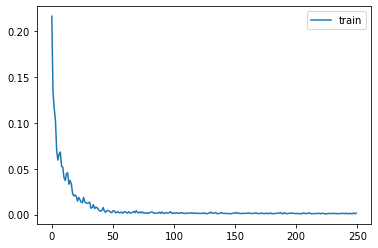

In [20]:
plt.plot(train_loss, label='train');
plt.legend();

In [21]:
unet = trained_model

In [22]:
# Evaluate the model on all datasets

unet.eval()

for group in ['train']:
    
    i=0
    track_loss = 0
    
    for batch in dataloader[group]: 
        
            data = batch['t1']['data'].to(device)
            
            with torch.no_grad():
                
                output = unet(data)
                loss = criterion(output,data)
                
                track_loss += loss.item()
                i+=1
                
    print(group, ': loss per batch = ', track_loss/i)

train : loss per batch =  0.0005529393383767456


In [23]:
# Visualize the output (train_dev and test_dev)

# Generate sample from two dev datasets
train_input = next(enumerate(dataloader['train']))

In [24]:
# Run network on samples
train_output = unet(train_input[1]['t1']['data'].to(device))

In [25]:
# Extract latent representations

#train_latent = unet.output_latent_representations(train_input[1]['t1']['data'].to(device))

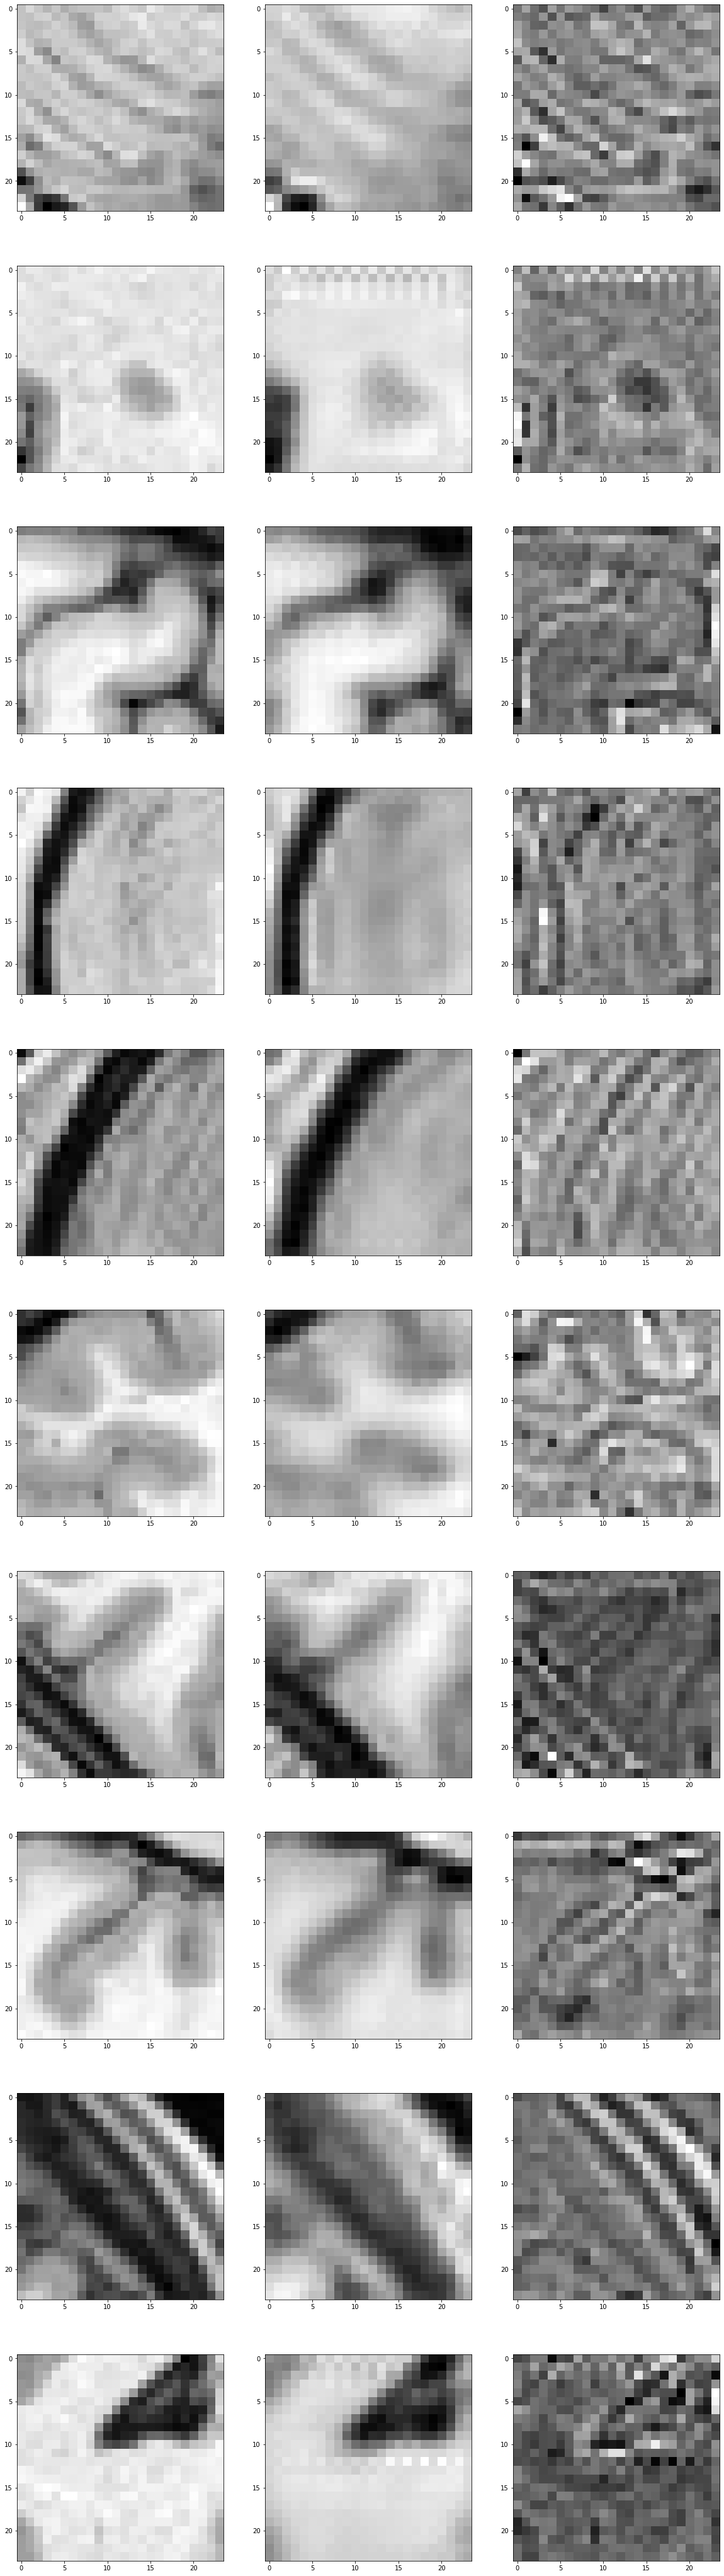

In [26]:
# Visualize train sample

inputs = train_input[1]['t1']['data'].to('cpu')
#latent = train_latent.cpu().detach().numpy()
outputs = train_output.cpu().detach().numpy()

fig = plt.figure(figsize=(20,75))

for i in range(outputs.shape[0]):
    
    plt.subplot(outputs.shape[0],3,3*i+1)
    plt.imshow(inputs[i,0,:,:,5],cmap='gray');
    
    plt.subplot(outputs.shape[0],3,3*i+2)
    plt.imshow(outputs[i,0,:,:,5], cmap ='gray')
    
    plt.subplot(outputs.shape[0],3,3*i+3)
    plt.imshow(inputs[i,0,:,:,5]-outputs[i,0,:,:,5], cmap ='gray')
    
plt.show()

# Evaluate and visualize results for chiasms


train


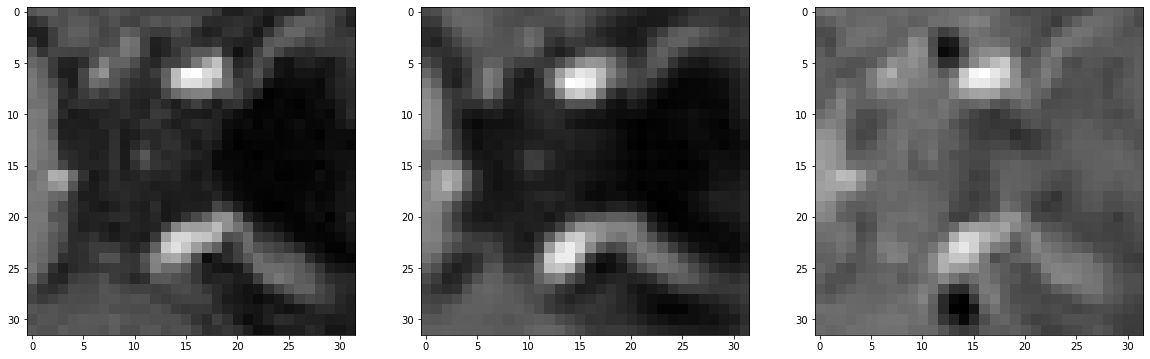

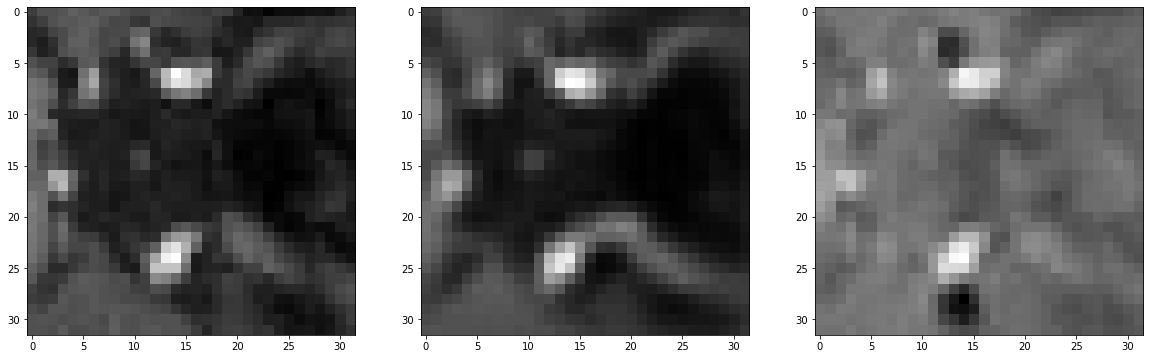

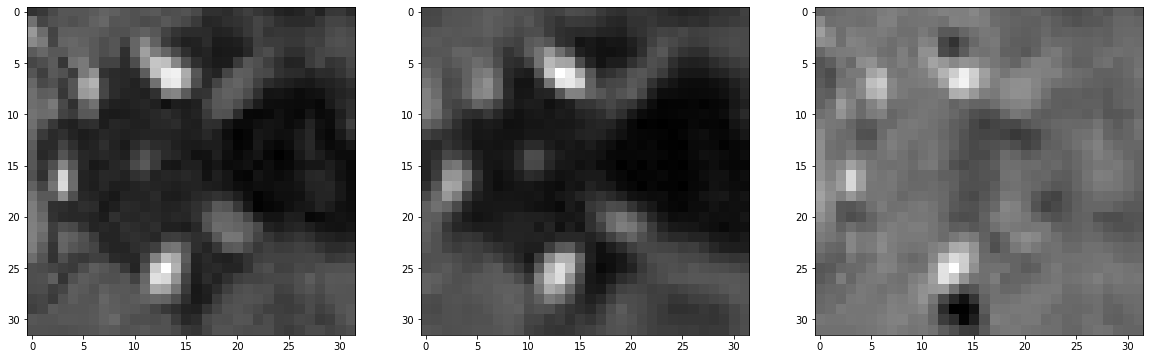

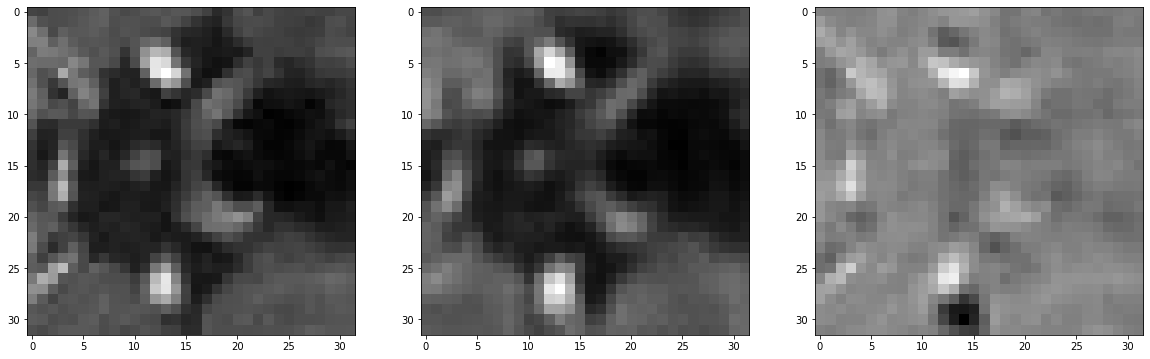

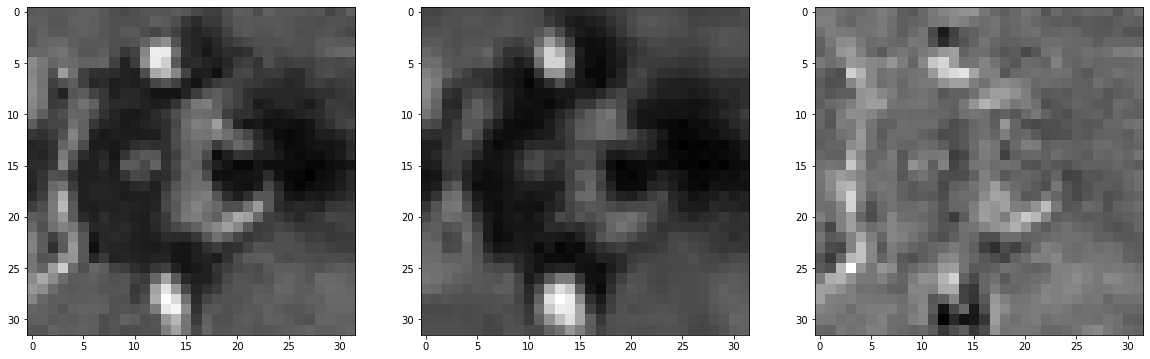

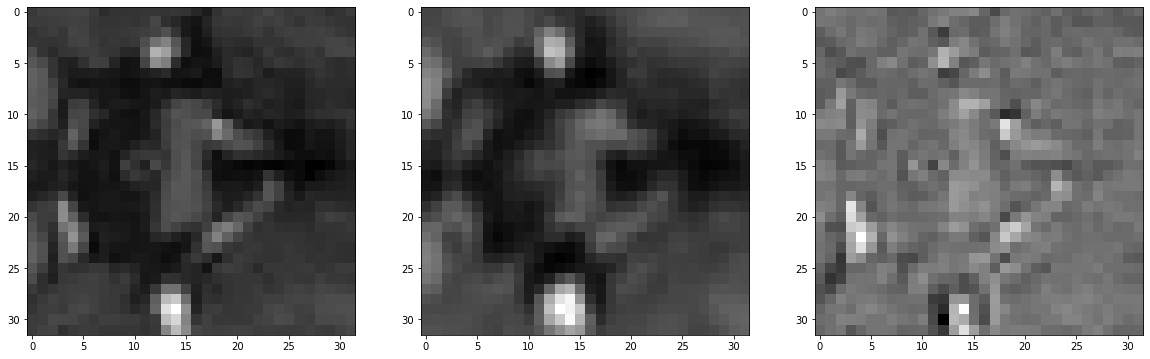

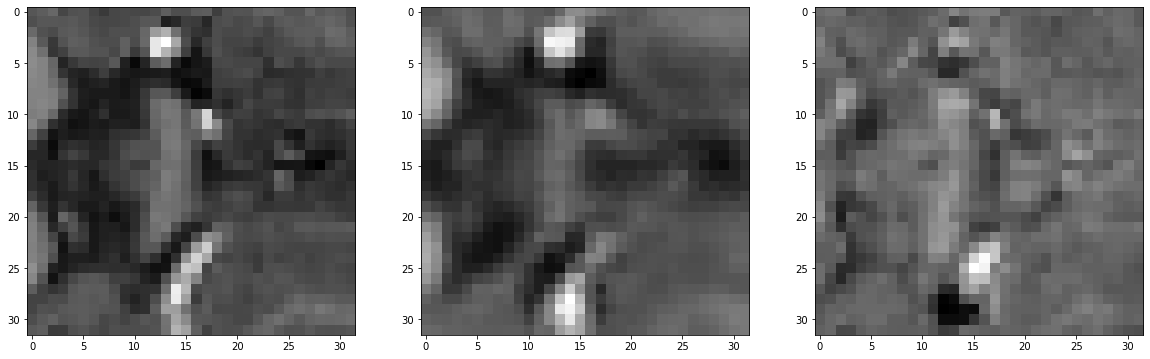

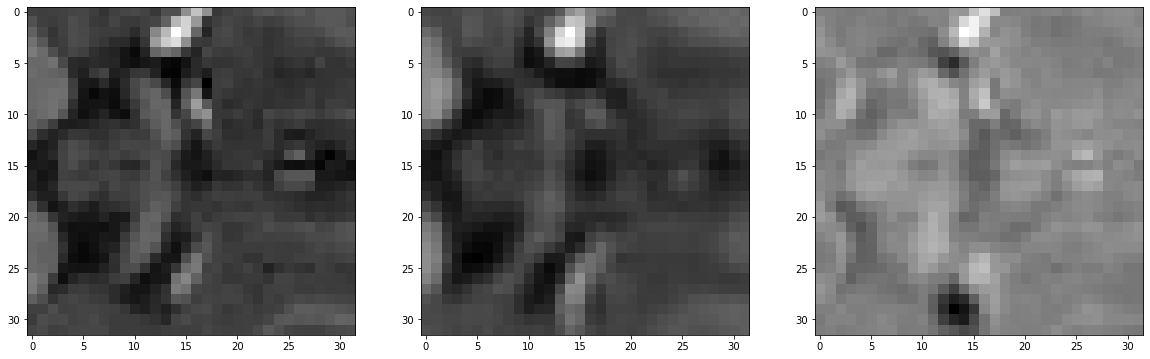

In [27]:
# Visualize results

unet.eval()

for group in ['train']:
    
    print(group)
    
    batch = next(enumerate(dataloader_chiasms[group]))
    
    data = batch[1]['t1']['data']
    
    output = unet(data.to(device))
    
    inputs = data.cpu().numpy()
    outputs = output.cpu().detach().numpy()   
    
    for i in range(outputs.shape[0]):
        for j in range(8):
            
            fig = plt.figure(figsize=(20,20))
        
            plt.subplot(outputs.shape[0],3,3*i+1)
            plt.imshow(inputs[i,0,:,:,j],cmap='gray');

            plt.subplot(outputs.shape[0],3,3*i+2)
            plt.imshow(outputs[i,0,:,:,j],cmap='gray');

            plt.subplot(outputs.shape[0],3,3*i+3)
            plt.imshow(inputs[i,0,:,:,j]-outputs[i,0,:,:,5],cmap='gray');
    
    
            plt.show()

In [28]:
batch = next(enumerate(dataloader_chiasms['train']))
print(batch[1]['t1']['data'].shape)

torch.Size([1, 1, 32, 32, 12])


In [32]:
i=0
for _ in unet.parameters():
    i+=1
print(i)

22


In [33]:
for parameter in unet.parameters():
    print(parameter)

Parameter containing:
tensor([[[[[ 1.0709e-01,  5.4275e-02, -1.6429e-01],
           [-1.3064e-02,  1.5452e-02,  8.8602e-02],
           [-1.6920e-01,  3.8158e-02, -3.8449e-02]],

          [[ 4.8307e-02, -2.6258e-02, -2.0566e-01],
           [-1.3920e-03, -5.2482e-02, -7.3643e-03],
           [-1.4685e-01, -5.6201e-03, -1.1288e-01]],

          [[ 1.1723e-01,  8.3695e-02, -1.2057e-01],
           [ 1.5456e-01,  1.8157e-01, -1.2520e-01],
           [-8.2316e-02, -1.8993e-01,  1.8613e-02]]]],



        [[[[-1.2346e-01,  5.2126e-02,  1.2608e-01],
           [ 6.8348e-02, -1.7998e-01, -1.3416e-01],
           [-9.7581e-02,  1.6624e-01, -1.1913e-01]],

          [[-1.0245e-02, -1.2971e-01, -1.4605e-01],
           [-1.4047e-01, -1.8274e-01, -7.2708e-02],
           [ 4.2326e-02,  8.2021e-02,  1.5381e-01]],

          [[-1.2028e-01,  1.9719e-01,  1.1695e-01],
           [ 1.0761e-01, -1.9725e-01,  8.5372e-02],
           [-9.1482e-02,  6.6440e-02, -8.4531e-02]]]],



        [[[[ 1.3551e-0

In [34]:
model_parameters = filter(lambda p: p.requires_grad, unet.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [35]:
print(params)

109025
